# Results of TSD, DANN, SCADANN models across 5 subjects starting at  subject_2

Library used can be downloaded from https://github.com/aonai/long_term_EMG_myo   
&emsp; Original by UlysseCoteAllard https://github.com/UlysseCoteAllard/LongTermEMG   
Dataset recorded by https://github.com/Suguru55/Wearable_Sensor_Long-term_sEMG_Dataset   
Extended robot project can be found in https://github.com/aonai/myo_robot_arm

### Notes
* weights for TSD are total of 15 training models, 5 for each wearing location
* weights for DANN and SCADANN are total of 12 trianing models, 4 for each wearing location


* training examples should have shape (3, 5, 40, 572, 252)
* training labels should have shape (3, 5, 40, 572)


* location 0, 1, and 2 corresponds to neutral position, inward rotation, and outward rotation respectively
* session mentioned below are days, so number of sessions is 10



In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd

In [2]:
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
os.chdir(code_dir)
from PrepareAndLoadData.process_data import read_data_training

# 0. Prepare Data
use `switch=1` to train across subjects and individually on each wearing location

### specify the directories used for running the code:
* `code_diar`: path to long_term_EMG_myo library
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape   
    (controlling_factor_1 x controlling_factor_2 x num_sessions_per_gesture x #examples_window*#mov(26*22=572) x processed_channel_shape(252 for TSD, (4,8,10) for ConvNet)
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for the first controlling factor.
    * weights for base model (TSD or ConvNet) contain m set of training model
    * weights for DANN and SCADANN contain m-1 set of trianing model (these models are trianed based on TSD, so they do not have a best_state_0.pt model). 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of dataset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving



* use `read_data_training` to process raw dataset
        

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_all_across_sub_start2"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_sub_start2/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_sub_start2/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_sub_start2/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
start_at_participant = 3
num_participant = 5
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=num_participant, 
#                    switch=1, start_at_participant=start_at_participant)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (3, 5, 40, 572, 252)
traning labels  (3, 5, 40, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each linear layer (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal; i.e. size of one training example 
    * 252 for TSD
* `learning_rate`= 0.002515
    

In [6]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]               # #session
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

number_of_cycles_total  40


# 1. TSD_DNN
* `train_fine_tuning`: used to train data using a base model (TSD or ConvNet)
    * running this function will save num_sessions sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_standard_model_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (num_session x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have num_sessions sets of dataloaders, each correspond to one session
   

In [7]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_standard_model_on_training_sessions, train_fine_tuning

In [8]:
# train_fine_tuning(examples_datasets_train, labels_datasets_train,
#                   num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
#                   number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
#                   batch_size=batch_size,
#                   feature_vector_input_length=feature_vector_input_length,
#                   learning_rate=learning_rate)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group 

train Loss: 0.00608165 Acc: 0.72734375
val Loss: 0.00021934 Acc: 0.81512238
New best validation loss: 0.00021934451965185313
Epoch 1 of 500 took 1.170s
Epoch 1/499
----------
train Loss: 0.00468080 Acc: 0.78925781
val Loss: 0.00021024 Acc: 0.83916084
Epoch 2 of 500 took 1.093s
Epoch 2/499
----------
train Loss: 0.00427060 Acc: 0.80673828
val Loss: 0.00016205 Acc: 0.87325175
Epoch 3 of 500 took 1.161s
Epoch 3/499
----------
train Loss: 0.00397447 Acc: 0.82148438
val Loss: 0.00023015 Acc: 0.81293706
Epoch 4 of 500 took 1.080s
Epoch 4/499
----------
train Loss: 0.00381852 Acc: 0.82875977
val Loss: 0.00014707 Acc: 0.89204545
Epoch 5 of 500 took 1.079s
Epoch 5/499
----------
train Loss: 0.00362347 Acc: 0.83452148
val Loss: 0.00015566 Acc: 0.875
Epoch 6 of 500 took 1.175s
Epoch 6/499
----------
train Loss: 0.00349076 Acc: 0.83994141
val Loss: 0.00013844 Acc: 0.89685315
Epoch 7 of 500 took 1.103s
Epoch 7/499
----------
train Loss: 0.00342625 Acc: 0.84682617
val Loss: 0.00013204 Acc: 0.8986014

train Loss: 0.00410536 Acc: 0.78173828
val Loss: 0.00018905 Acc: 0.81774476
Epoch 20 of 500 took 1.472s

Training complete in 0m 24s
Best val loss: 0.000209
Session:  1
<generator object Module.parameters at 0x7f09da0b40b0>
=> loading checkpoint '/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_sub_start2/TSD/participant_1/best_state_0.pt'
=> loaded checkpoint '/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_sub_start2/TSD/participant_1/best_state_0.pt' (epoch 9)
Epoch 0/499
----------
train Loss: 0.00720938 Acc: 0.69277344
val Loss: 0.00022723 Acc: 0.81687063
New best validation loss: 0.00022722736417830406
Epoch 1 of 500 took 1.283s
Epoch 1/499
----------
train Loss: 0.00540926 Acc: 0.7546875
val Loss: 0.00020896 Acc: 0.83435315
Epoch 2 of 500 took 1.151s
Epoch 2/499
----------
train Loss: 0.00499509 Acc: 0.77426758
val Loss: 0.00018718 Acc: 0.84440559
Epoch 3 of 500 took 

train Loss: 0.00943539 Acc: 0.56279297
val Loss: 0.00030993 Acc: 0.7076049
New best validation loss: 0.0003099286264472908
Epoch 1 of 500 took 1.160s
Epoch 1/499
----------
train Loss: 0.00657862 Acc: 0.66459961
val Loss: 0.00028843 Acc: 0.73033217
Epoch 2 of 500 took 1.142s
Epoch 2/499
----------
train Loss: 0.00594565 Acc: 0.69433594
val Loss: 0.00026650 Acc: 0.75218531
Epoch 3 of 500 took 1.123s
Epoch 3/499
----------
train Loss: 0.00557240 Acc: 0.70878906
val Loss: 0.00024197 Acc: 0.77141608
Epoch 4 of 500 took 1.138s
Epoch 4/499
----------
train Loss: 0.00534297 Acc: 0.72368164
val Loss: 0.00023778 Acc: 0.76748252
Epoch 5 of 500 took 1.116s
Epoch 5/499
----------
train Loss: 0.00512334 Acc: 0.73461914
val Loss: 0.00022712 Acc: 0.78190559
Epoch 6 of 500 took 1.110s
Epoch 6/499
----------
train Loss: 0.00503073 Acc: 0.73955078
val Loss: 0.00023752 Acc: 0.7701049
Epoch 7 of 500 took 1.088s
Epoch 7/499
----------
train Loss: 0.00489196 Acc: 0.74667969
val Loss: 0.00022621 Acc: 0.77972

train Loss: 0.00275275 Acc: 0.87060547
val Loss: 0.00008444 Acc: 0.92613636
Epoch 6 of 500 took 1.137s
Epoch 6/499
----------
train Loss: 0.00266401 Acc: 0.87485352
val Loss: 0.00008791 Acc: 0.92526224
Epoch 7 of 500 took 1.082s
Epoch 7/499
----------
train Loss: 0.00249176 Acc: 0.88212891
val Loss: 0.00009867 Acc: 0.9138986
Epoch 8 of 500 took 1.131s
Epoch 8/499
----------
train Loss: 0.00246397 Acc: 0.88515625
val Loss: 0.00009262 Acc: 0.91433566
Epoch 9 of 500 took 1.167s
Epoch 9/499
----------
train Loss: 0.00235770 Acc: 0.88935547
val Loss: 0.00008080 Acc: 0.93356643
Epoch 10 of 500 took 1.177s
Epoch 10/499
----------
train Loss: 0.00230373 Acc: 0.8925293
val Loss: 0.00008455 Acc: 0.92701049
Epoch 11 of 500 took 1.080s
Epoch 11/499
----------
train Loss: 0.00229800 Acc: 0.89169922
val Loss: 0.00007905 Acc: 0.9340035
Epoch 12 of 500 took 1.078s

Training complete in 0m 13s
Best val loss: 0.000157
Session:  4
<generator object Module.parameters at 0x7f09d819a6d0>
=> loading checkpoi

In [9]:
algo_name = "standard_TSD"
test_standard_model_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one g

In [10]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)

index_participant_list = list(range(start_at_participant-1,num_participant))   
if len(index_participant_list) < num_participant:
    index_participant_list.extend(list(range(start_at_participant-1))) 
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Participant_{i}' for i in index_participant_list],
                        columns = [f'Loc_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Loc_0,Loc_1,Loc_2
Participant_2,0.701399,0.782517,0.798077
Participant_3,0.360839,0.397727,0.399825
Participant_4,0.297727,0.300874,0.41958
Participant_0,0.417832,0.495804,0.478846
Participant_1,0.473951,0.590035,0.486888


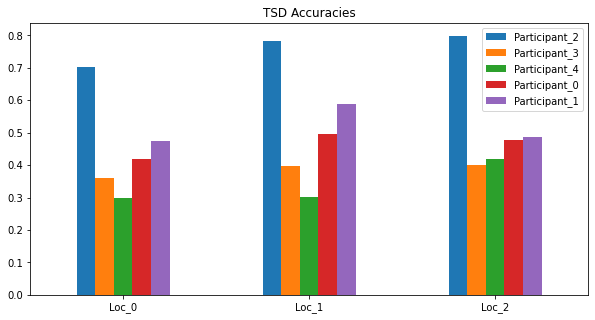

In [11]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

In [12]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [13]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc"
n_name = "Sub2"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name,
                            start_at_participant=start_at_participant)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (3, 5)
predictions =  (3, 5)
index_participant_list  [2, 3, 4, 0, 1]
accuracies_gestures =  (22, 15)


,Unnamed: 0,Loc0_Sub22,Loc0_Sub23,Loc0_Sub24,Loc0_Sub20,Loc0_Sub21,Loc1_Sub22,Loc1_Sub23,Loc1_Sub24,Loc1_Sub20,Loc1_Sub21,Loc2_Sub22,Loc2_Sub23,Loc2_Sub24,Loc2_Sub20,Loc2_Sub21
0,M0,1.000000,0.930769,0.976923,1.000000,0.915385,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,0.630769,0.111538,0.000000,0.000000,0.057692,0.842308,0.053846,0.000000,0.026923,0.288462,0.923077,0.026923,0.480769,0.046154,0.665385
2,M2,0.157692,0.000000,0.426923,0.084615,0.069231,0.957692,0.292308,0.003846,0.623077,0.515385,0.876923,0.573077,0.465385,0.873077,0.696154
3,M3,0.911538,0.023077,0.488462,0.057692,0.776923,0.842308,0.146154,0.069231,0.000000,0.896154,0.973077,0.169231,0.576923,0.776923,0.792308
4,M4,0.919231,0.196154,0.015385,0.057692,0.288462,0.915385,0.057692,0.000000,0.011538,0.073077,0.950000,0.038462,0.042308,0.146154,0.057692
5,M5,0.842308,0.007692,0.007692,0.573077,0.626923,0.965385,0.000000,0.019231,0.265385,0.826923,0.957692,0.000000,0.246154,0.615385,0.423077
6,M6,0.934615,0.123077,0.934615,1.000000,0.592308,0.923077,0.000000,0.838462,0.888462,0.165385,0.988462,0.030769,0.769231,0.934615,0.773077
7,M7,0.657692,0.007692,0.000000,0.219231,0.330769,0.984615,0.007692,0.134615,0.803846,0.884615,0.915385,0.000000,0.000000,0.007692,0.042308
8,M8,0.680769,0.834615,0.123077,0.765385,0.996154,0.592308,0.476923,0.000000,0.392308,0.950000,0.680769,0.965385,0.438462,0.465385,0.965385
9,M9,0.950000,1.000000,0.792308,0.880769,0.788462,0.223077,0.784615,0.165385,0.546154,0.934615,0.242308,0.742308,0.326923,0.569231,0.661538


# 2. DANN
* `train_DANN`: train DANN model using the first set of training weights from base model
    * num_sessions-1 sets of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [14]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [15]:
# train_DANN(examples_datasets_train, labels_datasets_train, 
#           num_kernels=num_kernels,
#           path_weights_fine_tuning=path_TSD,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           batch_size=batch_size,
#           feature_vector_input_length=feature_vector_input_length,
#           path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (20592, 252)    (20592,)
       one group 

Accuracy source 0.688330, main loss classifier 0.442808, source classification loss 0.745166, loss domain distinction 0.186970, accuracy domain distinction 0.500000
VALIDATION Loss: 1.60581410 Acc: 0.49694056
Epoch 2 of 500 took 2.306s
Accuracy source 0.701367, main loss classifier 0.430499, source classification loss 0.720993, loss domain distinction 0.186857, accuracy domain distinction 0.500000
VALIDATION Loss: 1.86482656 Acc: 0.47770979
Epoch 3 of 500 took 2.288s
Accuracy source 0.712500, main loss classifier 0.415124, source classification loss 0.691262, loss domain distinction 0.185375, accuracy domain distinction 0.500000
VALIDATION Loss: 1.52140069 Acc: 0.52054196
Epoch 4 of 500 took 2.274s
Accuracy source 0.720459, main loss classifier 0.403016, source classification loss 0.667764, loss domain distinction 0.184174, accuracy domain distinction 0.500000
VALIDATION Loss: 1.42212379 Acc: 0.52884615
New best validation loss:  1.4221237897872925
Epoch 5 of 500 took 2.451s
Accuracy s

Accuracy source 0.781494, main loss classifier 0.329201, source classification loss 0.525026, loss domain distinction 0.179784, accuracy domain distinction 0.500000
VALIDATION Loss: 0.68351370 Acc: 0.7263986
Epoch 17 of 500 took 2.520s
Accuracy source 0.785693, main loss classifier 0.325174, source classification loss 0.517051, loss domain distinction 0.179460, accuracy domain distinction 0.500000
VALIDATION Loss: 0.64928418 Acc: 0.73601399
Epoch 18 of 500 took 2.520s
Accuracy source 0.789111, main loss classifier 0.322103, source classification loss 0.510678, loss domain distinction 0.179712, accuracy domain distinction 0.500000
VALIDATION Loss: 0.66925579 Acc: 0.73164336
Epoch 19 of 500 took 2.316s
Accuracy source 0.784424, main loss classifier 0.323778, source classification loss 0.514107, loss domain distinction 0.179852, accuracy domain distinction 0.500000
VALIDATION Loss: 0.68427521 Acc: 0.72421329
Epoch 20 of 500 took 2.497s
Accuracy source 0.791260, main loss classifier 0.3213

Accuracy source 0.790234, main loss classifier 0.319743, source classification loss 0.506249, loss domain distinction 0.178802, accuracy domain distinction 0.500000
VALIDATION Loss: 0.50911897 Acc: 0.78452797
New best validation loss:  0.5091189742088318
Epoch 22 of 500 took 2.489s
Accuracy source 0.787695, main loss classifier 0.320867, source classification loss 0.508278, loss domain distinction 0.178956, accuracy domain distinction 0.500000
VALIDATION Loss: 0.59421051 Acc: 0.73776224
Epoch 23 of 500 took 2.367s
Accuracy source 0.793945, main loss classifier 0.315877, source classification loss 0.498413, loss domain distinction 0.179013, accuracy domain distinction 0.500000
VALIDATION Loss: 0.54890561 Acc: 0.7534965
Epoch 24 of 500 took 2.365s
Accuracy source 0.788818, main loss classifier 0.319959, source classification loss 0.506725, loss domain distinction 0.178674, accuracy domain distinction 0.500000
VALIDATION Loss: 0.49991384 Acc: 0.78452797
New best validation loss:  0.499913

Accuracy source 0.755615, main loss classifier 0.368090, source classification loss 0.598424, loss domain distinction 0.184276, accuracy domain distinction 0.500000
VALIDATION Loss: 1.16392493 Acc: 0.61975524
Epoch 4 of 500 took 2.321s
Accuracy source 0.753418, main loss classifier 0.367163, source classification loss 0.597262, loss domain distinction 0.183188, accuracy domain distinction 0.500000
VALIDATION Loss: 1.39251006 Acc: 0.57692308
Epoch 5 of 500 took 2.298s
Accuracy source 0.761572, main loss classifier 0.360783, source classification loss 0.584453, loss domain distinction 0.183437, accuracy domain distinction 0.500000
VALIDATION Loss: 1.27338803 Acc: 0.58479021
Epoch    15: reducing learning rate of group 0 to 5.0300e-04.
Epoch 6 of 500 took 2.301s
Accuracy source 0.775342, main loss classifier 0.336036, source classification loss 0.538327, loss domain distinction 0.179885, accuracy domain distinction 0.500000
VALIDATION Loss: 1.23921752 Acc: 0.60882867
Epoch 7 of 500 took 2

Accuracy source 0.749268, main loss classifier 0.372079, source classification loss 0.605028, loss domain distinction 0.186781, accuracy domain distinction 0.500000
VALIDATION Loss: 0.49755278 Acc: 0.78758741
New best validation loss:  0.4975527822971344
Epoch 2 of 500 took 2.284s
Accuracy source 0.747461, main loss classifier 0.374907, source classification loss 0.610821, loss domain distinction 0.186673, accuracy domain distinction 0.500000
VALIDATION Loss: 0.58374965 Acc: 0.75480769
Epoch 3 of 500 took 2.295s
Accuracy source 0.755420, main loss classifier 0.367518, source classification loss 0.596680, loss domain distinction 0.185754, accuracy domain distinction 0.500000
VALIDATION Loss: 0.57187247 Acc: 0.76005245
Epoch 4 of 500 took 2.332s
Accuracy source 0.756055, main loss classifier 0.361667, source classification loss 0.585563, loss domain distinction 0.184844, accuracy domain distinction 0.500000
VALIDATION Loss: 0.67799592 Acc: 0.71984266
Epoch 5 of 500 took 2.351s
Accuracy s

Accuracy source 0.783838, main loss classifier 0.333793, source classification loss 0.534391, loss domain distinction 0.179637, accuracy domain distinction 0.500000
VALIDATION Loss: 1.43126488 Acc: 0.55812937
Epoch 7 of 500 took 2.540s
Accuracy source 0.795898, main loss classifier 0.318171, source classification loss 0.503176, loss domain distinction 0.180448, accuracy domain distinction 0.500000
VALIDATION Loss: 1.09919322 Acc: 0.6131993
Epoch 8 of 500 took 2.472s
Accuracy source 0.794971, main loss classifier 0.319571, source classification loss 0.505993, loss domain distinction 0.179866, accuracy domain distinction 0.500000
VALIDATION Loss: 1.17464042 Acc: 0.60227273
Epoch 9 of 500 took 2.312s
Accuracy source 0.798438, main loss classifier 0.313595, source classification loss 0.494255, loss domain distinction 0.179049, accuracy domain distinction 0.500000
VALIDATION Loss: 1.43343556 Acc: 0.55506993
Epoch 10 of 500 took 2.283s
Accuracy source 0.797119, main loss classifier 0.309785,

Accuracy source 0.754346, main loss classifier 0.375557, source classification loss 0.608899, loss domain distinction 0.198571, accuracy domain distinction 0.498877
VALIDATION Loss: 0.74797708 Acc: 0.71896853
New best validation loss:  0.747977077960968
Epoch 1 of 500 took 2.438s
Accuracy source 0.758789, main loss classifier 0.366022, source classification loss 0.592833, loss domain distinction 0.187982, accuracy domain distinction 0.500000
VALIDATION Loss: 0.75390816 Acc: 0.69886364
Epoch 2 of 500 took 2.291s
Accuracy source 0.758740, main loss classifier 0.365933, source classification loss 0.592832, loss domain distinction 0.188044, accuracy domain distinction 0.500000
VALIDATION Loss: 1.09200716 Acc: 0.64685315
Epoch 3 of 500 took 2.444s
Accuracy source 0.758594, main loss classifier 0.366395, source classification loss 0.594401, loss domain distinction 0.186746, accuracy domain distinction 0.500000
VALIDATION Loss: 0.75944722 Acc: 0.70629371
Epoch 4 of 500 took 2.333s
Accuracy so

Accuracy source 0.814941, main loss classifier 0.295397, source classification loss 0.458060, loss domain distinction 0.177893, accuracy domain distinction 0.500000
VALIDATION Loss: 0.47004107 Acc: 0.79982517
New best validation loss:  0.47004106640815735
Epoch 20 of 500 took 2.480s
Accuracy source 0.813525, main loss classifier 0.294888, source classification loss 0.456925, loss domain distinction 0.178484, accuracy domain distinction 0.500000
VALIDATION Loss: 0.52135408 Acc: 0.77447552
Epoch 21 of 500 took 3.434s
Accuracy source 0.812891, main loss classifier 0.297573, source classification loss 0.462557, loss domain distinction 0.178258, accuracy domain distinction 0.500000
VALIDATION Loss: 0.50070679 Acc: 0.78409091
Epoch 22 of 500 took 3.797s
Accuracy source 0.816113, main loss classifier 0.292106, source classification loss 0.451395, loss domain distinction 0.178558, accuracy domain distinction 0.500000
VALIDATION Loss: 0.50398481 Acc: 0.78365385
Epoch 23 of 500 took 3.620s
Accur

In [16]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one group XY train (20592, 252)    (20592,)
       one group XY valid (2288, 252)    (2288, 252)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (5720, 252)    (5720, 252)
       one g

In [17]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Participant_{i}' for i in index_participant_list],
                        columns = [f'Loc_{j}' for j in range(TSD_acc.shape[0])])
DANN_df

,Loc_0,Loc_1,Loc_2
Participant_2,0.701399,0.782517,0.798077
Participant_3,0.399301,0.434965,0.467308
Participant_4,0.493706,0.458042,0.530594
Participant_0,0.516608,0.549825,0.535315
Participant_1,0.542657,0.605245,0.463636


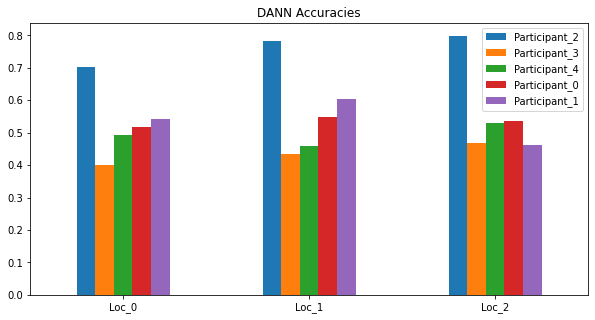

In [18]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

In [19]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc"
n_name = "Sub2"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_DANN, algo_name=algo_name,
                            start_at_participant=start_at_participant)
df = pd.read_csv(save_DANN+'/'+algo_name+'.csv')
df

ground_truths  =  (3, 5)
predictions =  (3, 5)
index_participant_list  [2, 3, 4, 0, 1]
accuracies_gestures =  (22, 15)


,Unnamed: 0,Loc0_Sub22,Loc0_Sub23,Loc0_Sub24,Loc0_Sub20,Loc0_Sub21,Loc1_Sub22,Loc1_Sub23,Loc1_Sub24,Loc1_Sub20,Loc1_Sub21,Loc2_Sub22,Loc2_Sub23,Loc2_Sub24,Loc2_Sub20,Loc2_Sub21
0,M0,1.000000,0.930769,0.807692,1.000000,0.903846,1.000000,0.980769,0.984615,1.000000,0.976923,1.000000,1.000000,0.992308,1.000000,1.000000
1,M1,0.630769,0.288462,0.330769,0.161538,0.092308,0.842308,0.715385,0.380769,0.596154,0.153846,0.923077,0.150000,0.703846,0.200000,0.376923
2,M2,0.157692,0.965385,0.696154,0.780769,0.719231,0.957692,0.492308,0.338462,0.342308,0.223077,0.876923,0.934615,0.876923,0.776923,0.607692
3,M3,0.911538,0.096154,0.415385,0.019231,0.846154,0.842308,0.465385,0.238462,0.084615,0.923077,0.973077,0.646154,0.561538,0.976923,0.792308
4,M4,0.919231,0.288462,0.561538,0.246154,0.273077,0.915385,0.261538,0.330769,0.323077,0.346154,0.950000,0.292308,0.465385,0.253846,0.192308
5,M5,0.842308,0.080769,0.657692,0.707692,0.496154,0.965385,0.000000,0.319231,0.484615,0.953846,0.957692,0.000000,0.600000,0.830769,0.530769
6,M6,0.934615,0.157692,0.488462,0.888462,0.330769,0.923077,0.046154,0.838462,0.796154,0.130769,0.988462,0.153846,0.815385,0.957692,0.665385
7,M7,0.657692,0.057692,0.303846,0.250000,0.515385,0.984615,0.196154,0.584615,0.880769,0.819231,0.915385,0.107692,0.238462,0.088462,0.153846
8,M8,0.680769,0.857692,0.476923,0.584615,0.988462,0.592308,0.480769,0.169231,0.480769,0.915385,0.680769,0.969231,0.492308,0.673077,0.953846
9,M9,0.950000,0.284615,0.811538,0.588462,0.580769,0.223077,0.415385,0.480769,0.996154,0.942308,0.242308,0.265385,0.284615,0.615385,0.742308


# 3. SCADANN

* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels: 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * num_sessions-1 sets of training weights will be saved


In [20]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import \
    run_SCADANN_training_sessions, test_network_SCADANN

In [ ]:
percentage_same_gesture_stable = 0.75 
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
                              num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
                              path_weights_to_save_to=path_SCADANN,
                              path_weights_Adversarial_training=path_DANN,
                              path_weights_Normal_training=path_TSD,
                              number_of_cycles_total = number_of_cycles_total, 
                              number_of_classes=number_of_classes,
                              learning_rate=learning_rate)

GET one participant_examples  (5, 40, 572, 252)
   GET one training_index_examples  (40, 572, 252)  at  0
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
   GET one training_index_examples  (40, 572, 252)  at  1
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
   GET one training_index_examples  (40, 572, 252)  at  2
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
   GET one training_index_examples  (40, 572, 252)  at  3
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880, 252)    (22880,)
   GET one training_index_examples  (40, 572, 252)  at  4
   GOT one group XY  (22880, 252)    (22880,)
       one group XY test  (0,)    (0,)
       one group XY train (22880,

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.0   AFTER:  0.0  

BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.4230769230769231   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  

BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  8
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.34615384615384615

Accuracy total 0.753547, main loss classifier 0.795025, source accuracy 0.681932 source classification loss 0.797931, target accuracy 0.825162 target loss 0.579724 accuracy domain distinction 0.499865 loss domain distinction 1.061970,
VALIDATION Loss: 0.41683885 Acc: 0.87339056
New best validation loss:  0.4168388471007347
Epoch 3 of 500 took 2.670s
Accuracy total 0.762482, main loss classifier 0.753587, source accuracy 0.686961 source classification loss 0.759918, target accuracy 0.838003 target loss 0.536280 accuracy domain distinction 0.499955 loss domain distinction 1.054884,
VALIDATION Loss: 0.40513250 Acc: 0.88125894
New best validation loss:  0.40513249520551076
Epoch 4 of 500 took 2.587s
Accuracy total 0.778781, main loss classifier 0.711363, source accuracy 0.705999 source classification loss 0.724348, target accuracy 0.851562 target loss 0.488628 accuracy domain distinction 0.500000 loss domain distinction 1.048745,
VALIDATION Loss: 0.32950937 Acc: 0.89234621
New best validat

Accuracy total 0.836117, main loss classifier 0.544425, source accuracy 0.774964 source classification loss 0.550092, target accuracy 0.897270 target loss 0.334072 accuracy domain distinction 0.500000 loss domain distinction 1.023428,
VALIDATION Loss: 0.28124630 Acc: 0.91094421
Epoch 28 of 500 took 2.483s
Accuracy total 0.833064, main loss classifier 0.546003, source accuracy 0.767690 source classification loss 0.554315, target accuracy 0.898438 target loss 0.332549 accuracy domain distinction 0.500000 loss domain distinction 1.025706,
VALIDATION Loss: 0.32996891 Acc: 0.88948498
Epoch 29 of 500 took 2.371s
Accuracy total 0.833917, main loss classifier 0.546758, source accuracy 0.771103 source classification loss 0.548359, target accuracy 0.896731 target loss 0.340492 accuracy domain distinction 0.500000 loss domain distinction 1.023322,
VALIDATION Loss: 0.27479767 Acc: 0.91702432
Epoch 30 of 500 took 2.392s
Accuracy total 0.835938, main loss classifier 0.542674, source accuracy 0.77774

BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7692307692307693   AFTER:  0.4  len before:  26   len after:  10
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.07692307692307693   AFTER:  0.0

BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.5   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.23076923076923078   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.0   AFTER:  0.0  len before:  26  

BEFORE:  0.8846153846153846   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  11
BEFORE:  0.46153846153846156   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  6
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26

BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.2692307692307692   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  0.6923076923076923   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26

STARTING TRAINING
Accuracy total 0.698015, main loss classifier 0.979624, source accuracy 0.677968 source classification loss 0.889041, target accuracy 0.718062 target loss 0.855169 accuracy domain distinction 0.499853 loss domain distinction 1.075194,
VALIDATION Loss: 0.48646006 Acc: 0.86171875
New best validation loss:  0.4864600606262684
Epoch 2 of 500 took 2.321s
Accuracy total 0.732508, main loss classifier 0.863275, source accuracy 0.703813 source classification loss 0.792529, target accuracy 0.761203 target loss 0.722629 accuracy domain distinction 0.499902 loss domain distinction 1.056962,
VALIDATION Loss: 0.44543844 Acc: 0.88359375
New best validation loss:  0.4454384416341782
Epoch 3 of 500 took 2.309s
Accuracy total 0.755257, main loss classifier 0.803465, source accuracy 0.719438 source classification loss 0.744701, target accuracy 0.791077 target loss 0.652835 accuracy domain distinction 0.500049 loss domain distinction 1.046975,
VALIDATION Loss: 0.43880985 Acc: 0.8609375


Accuracy total 0.802575, main loss classifier 0.663321, source accuracy 0.763070 source classification loss 0.631382, target accuracy 0.842079 target loss 0.486911 accuracy domain distinction 0.500000 loss domain distinction 1.041744,
VALIDATION Loss: 0.36795363 Acc: 0.88359375
Epoch 28 of 500 took 3.127s
Accuracy total 0.806309, main loss classifier 0.652424, source accuracy 0.766018 source classification loss 0.618001, target accuracy 0.846600 target loss 0.478806 accuracy domain distinction 0.500049 loss domain distinction 1.040207,
VALIDATION Loss: 0.32538454 Acc: 0.90742188
Epoch 29 of 500 took 2.618s
Accuracy total 0.809061, main loss classifier 0.650979, source accuracy 0.771325 source classification loss 0.618640, target accuracy 0.846796 target loss 0.475671 accuracy domain distinction 0.500049 loss domain distinction 1.038236,
VALIDATION Loss: 0.38013287 Acc: 0.88203125
Epoch 30 of 500 took 3.572s
Accuracy total 0.812156, main loss classifier 0.641110, source accuracy 0.77446

Accuracy total 0.836036, main loss classifier 0.571063, source accuracy 0.798349 source classification loss 0.535868, target accuracy 0.873722 target loss 0.401192 accuracy domain distinction 0.500000 loss domain distinction 1.025328,
VALIDATION Loss: 0.28083970 Acc: 0.91875
Epoch 54 of 500 took 2.148s
Accuracy total 0.834169, main loss classifier 0.570411, source accuracy 0.795008 source classification loss 0.538034, target accuracy 0.873329 target loss 0.397924 accuracy domain distinction 0.500000 loss domain distinction 1.024320,
VALIDATION Loss: 0.34630690 Acc: 0.88984375
Epoch    54: reducing learning rate of group 0 to 2.0120e-05.
Epoch 55 of 500 took 2.150s
Accuracy total 0.836969, main loss classifier 0.567268, source accuracy 0.798349 source classification loss 0.526904, target accuracy 0.875590 target loss 0.402882 accuracy domain distinction 0.500000 loss domain distinction 1.023753,
VALIDATION Loss: 0.29182466 Acc: 0.91601562
Epoch 56 of 500 took 2.181s
Accuracy total 0.835

BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.34615384615384615   AFTER:  0.34615384615384615  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  11
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.5384615384615384   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  nan  len before: 

BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.9230769230769231  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.9230769230769231   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  14
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.92307692307692

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.23076923076923078   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.0   AFTER:  0.0  len before:  26  

BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.6153846153846154  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.7307692307692307   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077

BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.34615384615384615   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.8846153846153846  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.3076923076923077   AFTER:  1.0  len before: 

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.19230769230769232   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.5769230769230769   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.5769230769230769   AFTER:  0.625  len before:  26   len after:  16
BEFORE:  0

BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0 

BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  3
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  11
BEFORE:  0.4230769230769231   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  2

STARTING TRAINING
Accuracy total 0.734608, main loss classifier 0.971240, source accuracy 0.686412 source classification loss 0.981638, target accuracy 0.782805 target loss 0.751275 accuracy domain distinction 0.500000 loss domain distinction 1.047835,
VALIDATION Loss: 0.46740508 Acc: 0.85439305
New best validation loss:  0.4674050819640066
Epoch 2 of 500 took 2.771s
Accuracy total 0.751671, main loss classifier 0.875633, source accuracy 0.702348 source classification loss 0.887889, target accuracy 0.800995 target loss 0.658219 accuracy domain distinction 0.500000 loss domain distinction 1.025790,
VALIDATION Loss: 0.41593460 Acc: 0.87239988
New best validation loss:  0.4159345956994038
Epoch 3 of 500 took 2.854s
Accuracy total 0.757968, main loss classifier 0.838219, source accuracy 0.711054 source classification loss 0.827434, target accuracy 0.804882 target loss 0.644205 accuracy domain distinction 0.500000 loss domain distinction 1.023988,
VALIDATION Loss: 0.41373583 Acc: 0.88326607

Accuracy total 0.794271, main loss classifier 0.707633, source accuracy 0.750311 source classification loss 0.703013, target accuracy 0.838231 target loss 0.508228 accuracy domain distinction 0.500000 loss domain distinction 1.020127,
VALIDATION Loss: 0.36634260 Acc: 0.89692642
New best validation loss:  0.36634260182287176
Epoch 28 of 500 took 2.983s
Accuracy total 0.797419, main loss classifier 0.692382, source accuracy 0.749300 source classification loss 0.689707, target accuracy 0.845538 target loss 0.491106 accuracy domain distinction 0.500000 loss domain distinction 1.019750,
VALIDATION Loss: 0.36363981 Acc: 0.89444272
New best validation loss:  0.36363981372001125
Epoch 29 of 500 took 2.865s
Accuracy total 0.795320, main loss classifier 0.690716, source accuracy 0.751088 source classification loss 0.677127, target accuracy 0.839552 target loss 0.500305 accuracy domain distinction 0.500000 loss domain distinction 1.019998,
VALIDATION Loss: 0.37845560 Acc: 0.88512884
Epoch 30 of 5

Accuracy total 0.797225, main loss classifier 0.693634, source accuracy 0.748057 source classification loss 0.691884, target accuracy 0.846393 target loss 0.491462 accuracy domain distinction 0.500000 loss domain distinction 1.019611,
VALIDATION Loss: 0.36198714 Acc: 0.89226948
Epoch 54 of 500 took 3.039s
Accuracy total 0.799479, main loss classifier 0.691175, source accuracy 0.756452 source classification loss 0.682167, target accuracy 0.842506 target loss 0.496284 accuracy domain distinction 0.500000 loss domain distinction 1.019489,
VALIDATION Loss: 0.35611825 Acc: 0.89382179
Epoch 55 of 500 took 3.328s
Accuracy total 0.797924, main loss classifier 0.687726, source accuracy 0.755830 source classification loss 0.670195, target accuracy 0.840019 target loss 0.501387 accuracy domain distinction 0.500000 loss domain distinction 1.019351,
VALIDATION Loss: 0.35731225 Acc: 0.89816827
Epoch 56 of 500 took 2.972s
Training complete in 2m 50s
['participant_1', 'participant_2', 'participant_0']

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.3076923076923077  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.5384615384615384   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.38461538461538464  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.346153846153846

BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.19230769230769232   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.4230769230769231   AFTER:  nan  len before:  26 

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.23076923076923078   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.0   AFTER:  0.0  len before:  26  

BEFORE:  0.7307692307692307   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.5769230769230769   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.38461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  1.0   AFTER:  1.0  len before:  26

BEFORE:  0.46153846153846156   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  0.6923076923076923  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  18
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7307692307692307   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  2

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.19230769230769232   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.5769230769230769   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.8076923076923077  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  17
BEFORE:  0.5769230769230769   AFTER:  0.625  len before:  26   len after:  16
BEFORE:  0

BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.46153846153846156   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.5384615384615384  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  0.8461538461538461  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  16
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.3333333333333333  len before:  26   len after:  15
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0

Finish segment dataset
Finish pseudo_labels
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  0.5769230769230769   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.6153846153846154   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0

BEFORE:  0.6538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.2692307692307692   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6538461538461539   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  14
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.9230769230769231   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.07692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.9615384615384616   AFTER:  1.0  le

BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  10
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  16
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  2

STARTING TRAINING
Accuracy total 0.750908, main loss classifier 0.935916, source accuracy 0.696181 source classification loss 0.994067, target accuracy 0.805634 target loss 0.667952 accuracy domain distinction 0.500000 loss domain distinction 1.049068,
VALIDATION Loss: 0.45018577 Acc: 0.85669192
New best validation loss:  0.4501857715845108
Epoch 2 of 500 took 2.821s
Accuracy total 0.771899, main loss classifier 0.836056, source accuracy 0.712279 source classification loss 0.883488, target accuracy 0.831518 target loss 0.583279 accuracy domain distinction 0.500000 loss domain distinction 1.026726,
VALIDATION Loss: 0.42045499 Acc: 0.87121212
New best validation loss:  0.4204549866914749
Epoch 3 of 500 took 2.815s
Accuracy total 0.779119, main loss classifier 0.796002, source accuracy 0.725221 source classification loss 0.831535, target accuracy 0.833018 target loss 0.555203 accuracy domain distinction 0.500000 loss domain distinction 1.026328,
VALIDATION Loss: 0.35143877 Acc: 0.89741162

BEFORE:  0.34615384615384615   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  9
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  10
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.7307692307692307   AFTER:  nan  len

BEFORE:  0.6923076923076923   AFTER:  1.0  len before:  26   len after:  15
BEFORE:  0.46153846153846156   AFTER:  0.0  len before:  26   len after:  11
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  8
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.8461538461538461   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.46153846153846156   AFTER:  1.0  len before:  26   len after:  1
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  2

STARTING TRAINING
Accuracy total 0.709548, main loss classifier 0.929291, source accuracy 0.678106 source classification loss 0.845721, target accuracy 0.740989 target loss 0.796840 accuracy domain distinction 0.499664 loss domain distinction 1.080106,
VALIDATION Loss: 0.44693304 Acc: 0.84959816
New best validation loss:  0.44693304053167016
Epoch 2 of 500 took 2.187s
Accuracy total 0.750959, main loss classifier 0.787432, source accuracy 0.709548 source classification loss 0.727090, target accuracy 0.792370 target loss 0.635996 accuracy domain distinction 0.500000 loss domain distinction 1.058888,
VALIDATION Loss: 0.44997548 Acc: 0.85112897
Epoch 3 of 500 took 2.299s
Accuracy total 0.764618, main loss classifier 0.754527, source accuracy 0.723926 source classification loss 0.696923, target accuracy 0.805311 target loss 0.602171 accuracy domain distinction 0.499808 loss domain distinction 1.049799,
VALIDATION Loss: 0.39666270 Acc: 0.87179487
New best validation loss:  0.396662697196006

Accuracy total 0.827837, main loss classifier 0.565911, source accuracy 0.781825 source classification loss 0.530941, target accuracy 0.873850 target loss 0.395577 accuracy domain distinction 0.500000 loss domain distinction 1.026527,
VALIDATION Loss: 0.28768178 Acc: 0.90700344
Epoch 28 of 500 took 2.416s
Accuracy total 0.827789, main loss classifier 0.567078, source accuracy 0.780579 source classification loss 0.534072, target accuracy 0.875000 target loss 0.394890 accuracy domain distinction 0.500000 loss domain distinction 1.025963,
VALIDATION Loss: 0.28223144 Acc: 0.91121316
New best validation loss:  0.2822314404496333
Epoch 29 of 500 took 2.226s
Accuracy total 0.828844, main loss classifier 0.558209, source accuracy 0.782784 source classification loss 0.522587, target accuracy 0.874904 target loss 0.388482 accuracy domain distinction 0.500000 loss domain distinction 1.026740,
VALIDATION Loss: 0.28749870 Acc: 0.90508993
Epoch 30 of 500 took 2.200s
Accuracy total 0.830617, main los

Accuracy total 0.839964, main loss classifier 0.535243, source accuracy 0.797834 source classification loss 0.500709, target accuracy 0.882094 target loss 0.365277 accuracy domain distinction 0.500000 loss domain distinction 1.022505,
VALIDATION Loss: 0.28718036 Acc: 0.91312667
Epoch 54 of 500 took 2.397s
Accuracy total 0.835219, main loss classifier 0.545487, source accuracy 0.788344 source classification loss 0.519685, target accuracy 0.882094 target loss 0.366698 accuracy domain distinction 0.500000 loss domain distinction 1.022953,
VALIDATION Loss: 0.28677121 Acc: 0.91159587
Epoch 55 of 500 took 2.316s
Accuracy total 0.840155, main loss classifier 0.532090, source accuracy 0.795725 source classification loss 0.503919, target accuracy 0.884586 target loss 0.355621 accuracy domain distinction 0.500000 loss domain distinction 1.023196,
VALIDATION Loss: 0.28488589 Acc: 0.90891695
Epoch 56 of 500 took 2.254s
Accuracy total 0.838334, main loss classifier 0.532470, source accuracy 0.79006

BEFORE:  0.7307692307692307   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.2692307692307692   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  7
BEFORE:  0.3076923076923077   AFTER:  1.0  len before:  26   len after:  2
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  0.38461538461538464  len before:  26   len after:  2

BEFORE:  0.3076923076923077   AFTER:  0.2  len before:  26   len after:  5
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5384615384615384   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  0.38461538461538464   AFTER:  0.5  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  0.6538461538461539  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.423

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  0.0  len before:  26   len after:  1
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  5
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.38461538461538464   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  15
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.3076923076923077   AFTER:  1.0  len before:  26   len after:  12
BEFORE:  0.7307692307692307   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.5384615384615384   

BEFORE:  0.19230769230769232   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  12
BEFORE:  0.2692307692307692   AFTER:  0.0  len before:  26   len after:  5
BEFORE:  0.4230769230769231   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.2  len before:  26   len after:  5
BEFORE:  0.6153846153846154   AFTER:  0.9615384615384616  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.07692307692307693   AFTER:  nan  len before:  26   len after:  0
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5769230769230769   AFTER:  1.0  len before:  26   len after:  4
BEFORE:  0.0   AFTER:  0.0  len before:  26  

BEFORE:  0.07692307692307693   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.11538461538461539   AFTER:  0.0  len before:  26   len after:  6
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.23076923076923078   AFTER:  0.0  len before:  26   len after:  9
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  14
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  2
BEFORE:  0.0   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.3076923076923077   AFTER:  0.46153846153846156  len before:  26   len after:  26
BEFORE:  0.8461538461538461   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.7692307692307693   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.15384615384615385   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.19230769230769232   AFTER:  nan  len before:  26   len after:  0
BEFORE:  

STARTING TRAINING
Accuracy total 0.765287, main loss classifier 0.820195, source accuracy 0.745270 source classification loss 0.703483, target accuracy 0.785304 target loss 0.729025 accuracy domain distinction 0.500000 loss domain distinction 1.039411,
VALIDATION Loss: 0.41427112 Acc: 0.87938005
New best validation loss:  0.41427112006126565
Epoch 2 of 500 took 2.588s
Accuracy total 0.784206, main loss classifier 0.738568, source accuracy 0.762838 source classification loss 0.642018, target accuracy 0.805574 target loss 0.629199 accuracy domain distinction 0.500000 loss domain distinction 1.029592,
VALIDATION Loss: 0.44655602 Acc: 0.85849057
Epoch 3 of 500 took 2.620s
Accuracy total 0.790541, main loss classifier 0.713853, source accuracy 0.764105 source classification loss 0.634631, target accuracy 0.816976 target loss 0.587444 accuracy domain distinction 0.500000 loss domain distinction 1.028151,
VALIDATION Loss: 0.39191438 Acc: 0.88645553
New best validation loss:  0.391914381625804

In [ ]:
algo_name = "SCADANN"
test_network_SCADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

In [ ]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Participant_{i}' for i in index_participant_list],
                        columns = [f'Loc_{j}' for j in range(TSD_acc.shape[0])])
SCADANN_df

In [ ]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

In [ ]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc"
n_name = "Sub2"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_SCADANN, algo_name=algo_name,
                            start_at_participant=start_at_participant)
df = pd.read_csv(save_SCADANN+'/'+algo_name+'.csv')
df

# Conclusion
Suppose there is a ndarray of NxM dataloaders, then N group of models will be trained, and each group will have M model. Each group is independent of the other, and each model within a group is dependent on its previous training weights.

In general, overall accuracies of SCADANN are better than DANN, and DANN is better than TSD.
Occasionally accuracies of SCADANN end up a little smaller than DANN, reasons may be lack of datasets put into training model (fixed) and non-optimal percentage_same_gesture_sable (fixed). Code should be reproducible if processed dataset sticks to the shape defined above.  

The amount of increase in accuracies from DANN to SCADANN looks random. But if the base model is better at classifying one session, then its corresponding SCADANN is also better at classifying the same session. Given such result, to obtain the best performance from SCADANN, a good model trained with good data should be the starting point.

* What to check if sth goes wrong:
    * percentage_same_gesture_sable
    * number of cycles or sessions
    * shape of dataloaders (combination of train, test, valid should include all dataset)
    * shape of procssed datasets
    * directory paths of weights and results
    * if weights are stored or loaded correclty

Below is the accumulative accuracies of individual participant over all sessions. In general, SCADANN increase performance. Accuracy over all participants is dependant on how good participant_0 model is when testing on other participants.

In [ ]:
accu_acc_TSD = []
accu_acc_DANN = []
accu_acc_SCADANN = []

for i in range(1,DANN_acc.shape[1]+1):
    accu_acc_TSD.append(np.mean(TSD_acc[:,:i]))
    accu_acc_DANN.append(np.mean(DANN_acc[:,:i]))
    accu_acc_SCADANN.append(np.mean(SCADANN_acc[:,:i]))

accu_df = pd.DataFrame([accu_acc_TSD, accu_acc_DANN, accu_acc_SCADANN],
                      index = ["TSD", "DANN", "SCADANN"],
                     columns =[f'Participant_{i}' for i in range(DANN_acc.shape[1])])
accu_df

In [ ]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

In [ ]:
diff_df = SCADANN_df-TSD_df
diff_df = diff_df.drop('Participant_2')
display(diff_df)
diff_df.to_csv(save_TSD+'/diff_results/across_sub2_diff.csv')

In [ ]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 8),textcoords='offset points')

Each participant model is trained based on the previous participant. Looking only at the average accuracy of individual participants among all sessions above, both overall and individual accuracies are increasing (the overall accuracy increases from 54% to 63%), so SCADANN is feasible in improving accuracy when trained across subjects. However, since the base model trained using subject_0 is not good at predicting gestures for other subjects, the overall accuracy remains low compared to across location training. SCADANN increase accuracy the most when training at location 1 and subject 3 (from 39% to 54%), and it increases accuracy the least when training at location 2 and subject 4 (from 37% to 42%). 